In [1]:
import torch.nn.functional as F
from timeit import default_timer
from utilities3 import *
import matplotlib.pyplot as plt
# import tqdm
# import skfmm

torch.manual_seed(0)
np.random.seed(0)
import sys
print(sys.path)

['/home/g202321530/Yang/MS_homework/GEOP_691/FNO_eikonal', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/g202321530/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages/IPython/extensions', '/home/g202321530/.ipython']


In [19]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class U_net(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, dropout_rate):
        super(U_net, self).__init__()
        self.input_channels = input_channels
        self.conv1 = self.conv(input_channels, output_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2, dropout_rate=dropout_rate)
        self.conv2 = self.conv(output_channels, output_channels * 2, kernel_size=kernel_size, padding=(kernel_size - 1) // 2, dropout_rate=dropout_rate)
        self.conv3 = self.conv(output_channels * 2, output_channels * 4, kernel_size=kernel_size, padding=(kernel_size - 1) // 2, dropout_rate=dropout_rate)

        self.deconv4 = self.deconv(output_channels * 4, output_channels * 2)
        self.deconv3 = self.deconv(output_channels * 2, output_channels)
        self.deconv2 = self.deconv(output_channels, output_channels)

        self.output_layer = self.output(output_channels, output_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2, dropout_rate=dropout_rate)

    def forward(self, x):
        out_conv1 = self.conv1(x)
        out_conv2 = self.conv2(out_conv1)
        out_conv3 = self.conv3(out_conv2)
        
        out_deconv4 = self.deconv4(out_conv3)
        concat4 = torch.cat((out_conv2, out_deconv4), dim=1)
        out_deconv3 = self.deconv3(concat4)
        concat3 = torch.cat((out_conv1, out_deconv3), dim=1)
        out_deconv2 = self.deconv2(concat3)
        out = self.output_layer(out_deconv2)

        return out

    def conv(self, in_planes, output_channels, kernel_size, padding, dropout_rate):
        return nn.Sequential(
            nn.Conv2d(in_planes, output_channels, kernel_size=kernel_size,
                      stride=1, padding=padding),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )

    def deconv(self, input_channels, output_channels):
        return nn.ConvTranspose2d(input_channels, output_channels, kernel_size=3,
                                  stride=1, padding=1, output_padding=0)

    def output(self, input_channels, output_channels, kernel_size, padding, dropout_rate):
        return nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size,
                         stride=1, padding=padding)
    
class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)
#         nn.LeakyReLU(negative_slope=5e-2)

    def forward(self, x):
        x = self.mlp1(x)
#         x = nn.BatchNorm2d(x)
        x = nn.LeakyReLU(negative_slope=2e-2)(x)
        x = self.mlp2(x)
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 1 # pad the domain if input is non-periodic

        self.p = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv4 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.mlp4 = MLP(self.width, self.width, self.width)       
        self.unet3 = U_net(self.width, self.width, 3, 0)
        self.unet4 = U_net(self.width, self.width, 3, 0)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.w4 = nn.Conv2d(self.width, self.width, 1)

        self.q = MLP(self.width, 1, self.width * 4) # output channel is 1: u(x, y)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2]
        x=x.to(torch.float32)
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 3, 1, 2)  # x1 shape: torch.Size([20, 32, 85, 85])           
        x = F.pad(x, [0,self.padding, 0,self.padding])  # x2 shape:  torch.Size([20, 32, 94, 94])
        x1 = self.conv0(x)     # x3 shape: torch.Size([20, 32, 94, 94])
        x1 = self.mlp0(x1)
        x2 = self.w0(x)        # x4 shape: torch.Size([20, 32, 94, 94])
        x = x1 + x2           # x5 shape: torch.Size([20, 32, 94, 94])
        x = nn.LeakyReLU(0.2)(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = nn.LeakyReLU(0.2)(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = nn.LeakyReLU(0.2)(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
#         x2 = self.unet3(x)
        x = x1 + x2
        x = nn.LeakyReLU(0.2)(x)
        
#         x1 = self.conv4(x)
#         x1 = self.mlp4(x1)
#         x2 = self.w4(x)
#         x2 = self.unet4(x)
#         x = x1 + x2
#         x = nn.LeakyReLU(0.2)(x)

        x = x[..., :-self.padding, :-self.padding]       # x6 shape: torch.Size([20, 32, 85, 85])
#         print('x6 shape:', x.shape)
        x = self.q(x)  # x7 shape: torch.Size([20, 1, 85, 85])
#         print('x7 shape:', x.shape)   
        x = x.permute(0, 2, 3, 1)   # x8 shape: torch.Size([20, 85, 85, 1])
#         print('x8 shape:', x.shape)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)
    
def plot_figure_gpu(fig_plot, shape=[101, 101], title='Predicted tau'):
    plt.style.use('default')

    plt.figure(figsize=(4,4))
    fig_plot = fig_plot.cpu()
    fig_plot = fig_plot.detach().numpy()
    fig_plot = np.reshape(fig_plot, shape)
    ax = plt.gca()
    im = ax.imshow(fig_plot, extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


    plt.xlabel('Offset (km)', fontsize=12)
    plt.xticks(fontsize=10)

    plt.ylabel('Depth (km)', fontsize=12)
    plt.yticks(fontsize=10)

    plt.title(title, fontsize=15, fontweight='bold')

    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="6%", pad=0.15)

    cbar = plt.colorbar(im, cax=cax)

    cbar.set_label('seconds',size=10)
    cbar.ax.tick_params(labelsize=10)
    plt.tight_layout()
    
def plot_figure_cpu(fig_plot, shape=[101, 101], title='Diff tau'):
    fig_plot = np.reshape(fig_plot, shape)
    plt.style.use('default')

    plt.figure(figsize=(4,4))
#     Tau_diff = test_y_1-test_predict_1
    ax = plt.gca()
    im = ax.imshow(np.abs(fig_plot), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


    plt.xlabel('Offset (km)', fontsize=14)
    plt.xticks(fontsize=10)

    plt.ylabel('Depth (km)', fontsize=14)
    plt.yticks(fontsize=10)

    plt.title(title, fontsize=15, fontweight='bold')

    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="6%", pad=0.15)

    cbar = plt.colorbar(im, cax=cax)

    cbar.set_label('seconds',size=10)
    cbar.ax.tick_params(labelsize=10)
    plt.tight_layout()

def to_cpu_reshape(inputs, shape=[101, 101]):
    inputs = inputs.cpu()
    inputs = inputs.detach().numpy()
    inputs = np.reshape(inputs, [101, 101])
    
    return inputs

In [20]:
ntrain = 50
# ntest = 100

batch_size = 5
learning_rate = 0.001
epochs = 1000
# iterations = epochs*(ntrain//batch_size)
# print(iterations)

modes1 = 10
modes2 = 10
width = 32

r = 5
h = int(((421 - 1)/r) + 1)
s = h
print(h, s)

85 85


In [21]:
T_data = np.load('./train_data/Un_T_50_101.npy')
T0_data = np.load('./train_data/Un_T0_50_101.npy')
Tau_data = np.load('./train_data/Un_Tau_50_101.npy')

inputs = Tau_data[:, :, :]
inputs = np.reshape(inputs, [50, 101, 101, 1])
inputs = torch.tensor(inputs, requires_grad=True).cuda()
inputs = inputs.double()

labels = T_data[:, :, :]
labels = torch.tensor(labels, requires_grad=True).cuda()
labels = labels.double()

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(inputs, labels), batch_size=batch_size, shuffle=True)

In [22]:
################################################################
# training and evaluation
################################################################
model = FNO2d(modes1, modes2, width).cuda()
print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

myloss =  nn.MSELoss()
# myloss =  LpLoss()
# y_normalizer.cuda()

def train():
    Loss = []
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for inputs, labels in train_loader:

            inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.float()
            labels = labels.float()

            optimizer.zero_grad()
            out = model(inputs).reshape(batch_size, 101, 101)
            out = out.float()
            
            loss = myloss(out.view(batch_size,-1), labels.view(batch_size,-1))
            Loss.append(loss.item())
            loss.backward()
            
            optimizer.step()
            scheduler.step()
        t2 = default_timer()
        
        if ep % (epochs // 50) == 0:
            print(f"Epoch: {ep}/{epochs}, Loss: {loss.item()}, Time: {t2-t1}")
        model.eval()
        
    return model, Loss
# %mkdir model
model, Loss = train()

print('[Training] Finished.')
torch.save(model, "./model/best_model_101_Tau_UN")
model.eval()

2493921
Epoch: 0/1000, Loss: 0.009558532387018204, Time: 0.11670923139899969
Epoch: 20/1000, Loss: 5.9419548051664606e-05, Time: 0.10785384103655815
Epoch: 40/1000, Loss: 7.407373232126702e-06, Time: 0.10632068943232298
Epoch: 60/1000, Loss: 9.945470083039254e-06, Time: 0.10337286815047264
Epoch: 80/1000, Loss: 6.703592134726932e-06, Time: 0.1108660539612174
Epoch: 100/1000, Loss: 4.87689476358355e-06, Time: 0.10682200361043215
Epoch: 120/1000, Loss: 2.6828893169295043e-06, Time: 0.10395985282957554
Epoch: 140/1000, Loss: 7.150847523007542e-06, Time: 0.10501233581453562
Epoch: 160/1000, Loss: 1.6643007256789133e-05, Time: 0.10534980334341526
Epoch: 180/1000, Loss: 1.914521817525383e-06, Time: 0.11298170313239098
Epoch: 200/1000, Loss: 1.5724837794550695e-05, Time: 0.10713980626314878
Epoch: 220/1000, Loss: 5.92061405768618e-06, Time: 0.10712648462504148
Epoch: 240/1000, Loss: 1.3152763358448283e-06, Time: 0.1066437503322959
Epoch: 260/1000, Loss: 1.2235219628564664e-06, Time: 0.1113795

FNO2d(
  (p): Linear(in_features=3, out_features=32, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (conv4): SpectralConv2d()
  (mlp0): MLP(
    (mlp1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp1): MLP(
    (mlp1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp2): MLP(
    (mlp1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp3): MLP(
    (mlp1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp4): MLP(
    (mlp1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (unet3): U_net(
    (conv1): Sequential(
      (0): Conv2d(32, 32, kernel_size=

10000


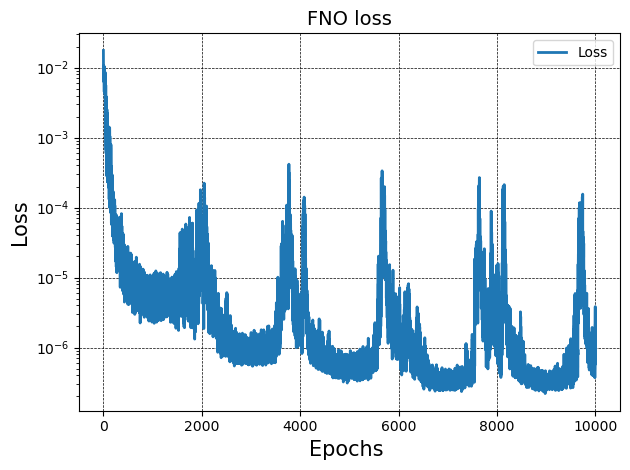

In [23]:
################################################################
# Plotting loss curve
################################################################
print(len(Loss))
plt.semilogy(Loss, label="Loss", linewidth=2) # Plots the total loss

plt.title("FNO loss", fontsize=14)   # Sets the title of the figure

plt.xlabel("Epochs ", fontsize=15)              # Sets the x-axis label of the figure
plt.ylabel("Loss", fontsize=15,)                # Sets the y-axis label of the figure

plt.grid(color = 'black', linestyle = '--', linewidth = 0.5) # Sets the grid of the figure

plt.legend(loc="upper right")   # Sets the legend of the figure

plt.tight_layout()

# %mkdir figs
plt.savefig("./figs/FNO_Loss_101_2000_tau_UN.pdf", format="pdf", bbox_inches="tight", dpi=300) # Saves the figure
plt.savefig("./figs/FNO_Loss_101_2000_tau_UN.png", format="png", bbox_inches="tight", dpi=300)

plt.show() # Displays the figure

In [24]:
################################################################
# testing an evaluation
################################################################
T_test = np.load('./test_data/Un_T_1_101.npy')
T0_test = np.load('./test_data/Un_T0_1_101.npy')
Tau_test = np.load('./test_data/Un_Tau_1_101.npy')
model = torch.load('./model/best_model_101_Tau_UN')
model.cuda()

test_x_1 = Tau_test
test_x_1 = np.reshape(test_x_1, [1, 101, 101, 1])
test_x_1 = torch.tensor(test_x_1, requires_grad=True).cuda()
test_x_1 = test_x_1.float()

test_y_1 = T_test
test_y_1 = torch.tensor(test_y_1, requires_grad=True).cuda()
test_y_1 = test_y_1.float()


test_predict_1 = model(test_x_1).reshape(101, 101)
print(test_predict_1.shape, T0_test.shape)

torch.Size([101, 101]) (1, 101, 101)


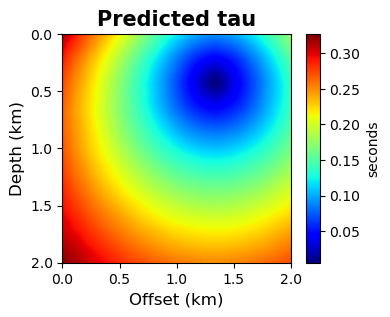

In [25]:
################################################################
# Ploting result
################################################################
from mpl_toolkits.axes_grid1 import make_axes_locatable
zmin = 0.; zmax = 2.; deltaz = 0.02;
xmin = 0.; xmax = 2.; deltax = 0.02;

plot_figure_gpu(test_predict_1, shape=[101, 101], title='Predicted tau')

plt.savefig("./figs/fno_preict_tau_new_101_UN.pdf", format='pdf', bbox_inches="tight", dpi=300)
plt.savefig("./figs/fno_preict_tau_new_101_UN.png", format='png', bbox_inches="tight", dpi=300)

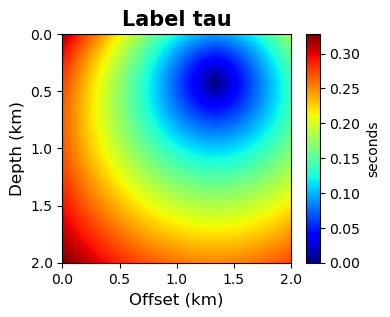

In [26]:
plot_figure_gpu(test_y_1, shape=[101, 101], title='Label tau')

plt.savefig("./figs/fno_label_tau_new_101_UN.pdf", format='pdf', bbox_inches="tight", dpi=300)
plt.savefig("./figs/fno_label_tau_new_101_UN.png", format='png', bbox_inches="tight", dpi=300)

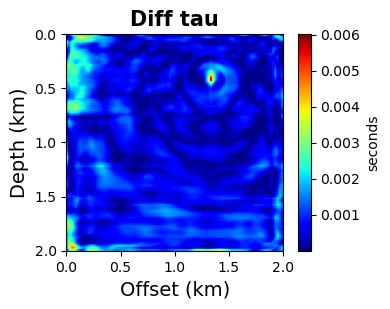

In [27]:
test_y_1 = to_cpu_reshape(test_y_1, shape=[101, 101])
test_predict_1 = to_cpu_reshape(test_predict_1, shape=[101, 101])
Tau_diff = test_y_1-test_predict_1

plot_figure_cpu(Tau_diff, title='Diff tau')

plt.savefig("./figs/fno_diff_tau_new_101_UN.pdf", format='pdf', bbox_inches="tight", dpi=300)
plt.savefig("./figs/fno_diff_tau_new_101_UN.png", format='png', bbox_inches="tight", dpi=300)

In [28]:
T0_test = np.reshape(T0_test, [101, 101])
T_predict = test_predict_1 + T0_test

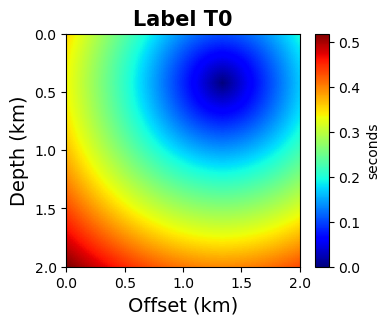

In [29]:
plot_figure_cpu(T0_test, title='Label T0', shape=[101, 101])


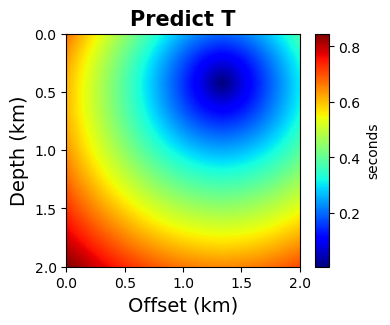

In [30]:


plot_figure_cpu(T_predict, shape=[101, 101], title='Predict T')

plt.savefig("./figs/fno_predict_T_new_101_UN.pdf", format='pdf', bbox_inches="tight", dpi=300)
plt.savefig("./figs/fno_predict_T_new_101_UN.png", format='png', bbox_inches="tight", dpi=300)

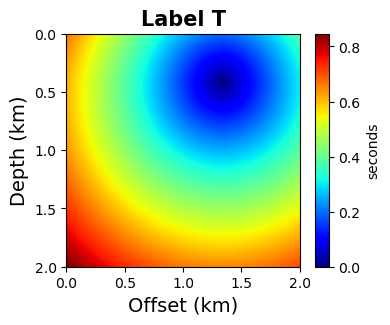

In [31]:
T_test = T0_test + test_y_1
plot_figure_cpu(T_test, shape=[101, 101], title='Label T')

plt.savefig("./figs/fno_label_T_new_101_UN.pdf", format='pdf', bbox_inches="tight", dpi=300)
plt.savefig("./figs/fno_label_T_new_101_UN.png", format='png', bbox_inches="tight", dpi=300)

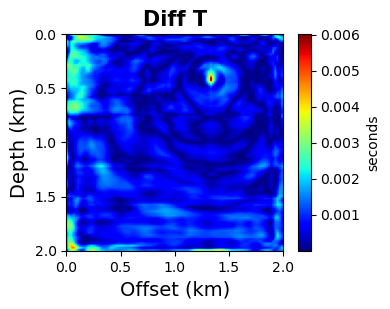

In [32]:
plot_figure_cpu(np.abs(T_predict-T_test), shape=[101, 101], title='Diff T')

plt.savefig("./figs/fno_diff_T_new_101_UN.pdf", format='pdf', bbox_inches="tight", dpi=300)
plt.savefig("./figs/fno_diff_T_new_101_UN.png", format='png', bbox_inches="tight", dpi=300)

/tmp/ipykernel_4184027/2772053021.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_ignches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("./figs/contours_101_new_UN.pdf", format='pdf', bbox_ignches="tight", dpi=300)
/tmp/ipykernel_4184027/2772053021.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_ignches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("./figs/contours_101_new_UN.png", format='png', bbox_ignches="tight", dpi=300)


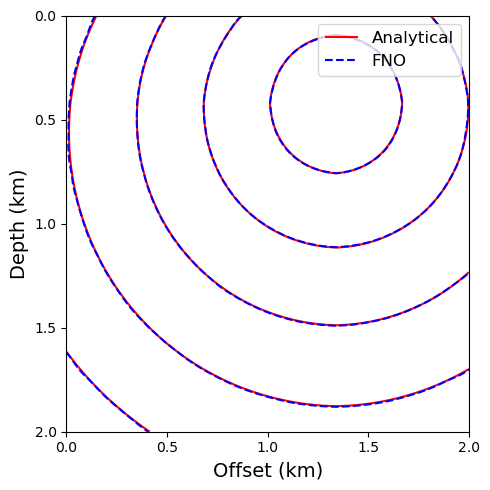

In [33]:
# Traveltime contour plots

plt.figure(figsize=(5,5))

ax = plt.gca()
im1 = ax.contour(T_test, 6, extent=[xmin,xmax,zmin,zmax], colors='r')
im2 = ax.contour(T_predict, 6, extent=[xmin,xmax,zmin,zmax], colors='b',linestyles = 'dashed')
# im3 = ax.contour(T_fsm, 6, extent=[xmin,xmax,zmin,zmax], colors='b',linestyles = 'dotted')

# ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().invert_yaxis()
h1,_ = im1.legend_elements()
h2,_ = im2.legend_elements()
# h3,_ = im3.legend_elements()
ax.legend([h1[0], h2[0]], ['Analytical', 'FNO'],fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.savefig("./figs/contours_101_new_UN.pdf", format='pdf', bbox_ignches="tight", dpi=300)
plt.savefig("./figs/contours_101_new_UN.png", format='png', bbox_ignches="tight", dpi=300)

In [34]:
# Determining the accuracy of the model by quantifying the difference between T_pred and T_data using Vector Norm
print(np.linalg.norm(T_predict-T_test)/np.linalg.norm(T_test))
print(np.linalg.norm(T_predict-T_test))

0.0020053879648560006
0.09220941942895192


In [35]:
# RMAE comparison of two different methods
print("RMAE of FNO =", 100 * abs(T_predict - T_test).mean() / T_test.mean(), '%')

RMAE of FNO = 0.17171308532895221 %
